# Fastjet with Awkward Arrays
This notebook demonstrates how to use [Fastjet in Python](https://github.com/scikit-hep/fastjet) with Awkward Arrays to cluster jets in particle physics. Using Awkward Arrays allows handling multi-event data and is therefore a fast and efficient way to use Fastjet for large datasets in Python. The [LHC-Olympics data](https://lhco2020.github.io/homepage/) is used for this example. The data consists of dijet events and we want to cluster the events to get the constituents and jet features of the two jets.

## Imports

In [1]:
import h5py
import awkward as ak
import energyflow as ef
import fastjet as fj
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import vector
from cycler import cycler

2023-09-16 01:16:44.656656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 01:16:45.476979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# define plot style
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#B6BFC3",
        "#3B515B",
        "#0271BB",
        "#E2001A",
    ]
)
mpl.rcParams["font.size"] = 15
mpl.rcParams["patch.linewidth"] = 1.25

## Load Data 
We load the LHC-Olympics data from an h5 file. The data is stored in a pandas dataframe and contains of up to 700 jet constituents per event that are described by the features: $p_T$, $\eta$, $\phi$. The dataset contains 1M QCD dijets background events and 100k W'->XY signal events.

In [3]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [4]:
# Load everything into memory
df = pd.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [5]:
# split data into signal and background
np_array = np.array(df)
background = np_array[np_array[:,2100]==0] 
signal = np_array[np_array[:,2100]==1]

In [6]:
# change the shape of the data to (n_events, n_particles, n_features)
qcd_data = background[:, :2100].reshape(-1, 700, 3)
sig_data = signal[:, :2100].reshape(-1, 700, 3)

In [7]:
# save lengths of signal and background data for later use
len_bckg = len(qcd_data)
len_sig = len(sig_data)
print(f"Background events: {len_bckg}")
print(f"Signal events: {len_sig}")

Background events: 1000000
Signal events: 100000


In [8]:
data_full = np.concatenate((qcd_data, sig_data), axis=0)

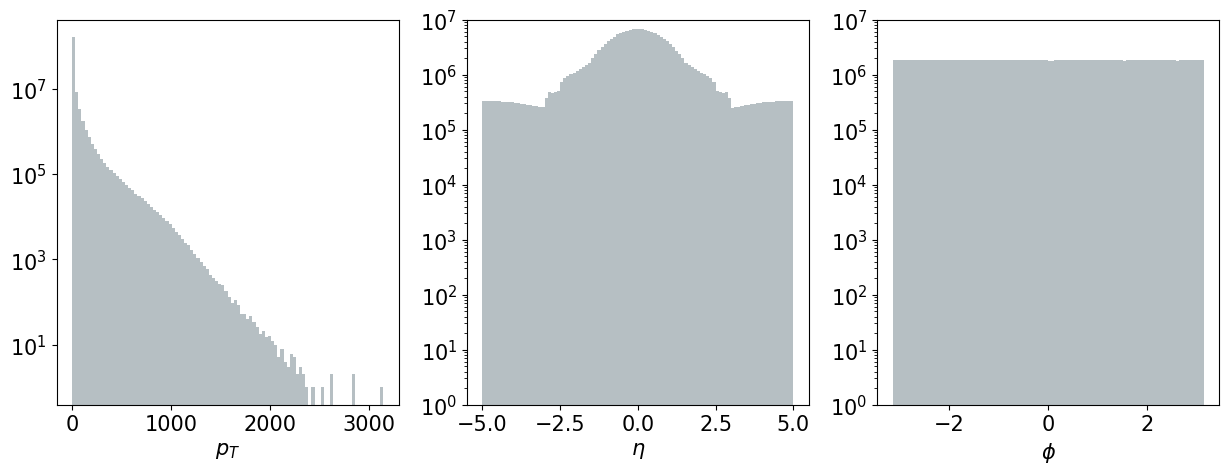

In [9]:
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data[:, :, index].flatten()[qcd_data[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 1:
        ax.set_ylim(1,)
    if index ==2 or index == 1:
        ax.set_ylim(1,1e7)
plt.show()

## Jet Clustering
The jet constituents will be clustered into jets. To allow for an efficient calculation, the data will be stored in awkward arrays. The jet clustering will be done using the [FastJet](http://fastjet.fr/) package. The FastJet package is a C++ library for jet finding. It is interfaced to Python using the [FastJet python](https://pypi.org/project/fastjet/) package.

Awkward arrays are like numpy arrays, but they can have jagged dimensions. This is useful for particle physics, where we have a variable number of particles in each event. To benefit from the speed of awkward, we need to transform our data into an awkward array. For this, we first remove the zero padding and then tell the awkward array that our input data is a 4vector with $p_T$, $\eta$, $\phi$, and $m$.

In [10]:
# to awkard array
zrs = np.zeros((data_full.shape[0], data_full.shape[1], 1))
data_with_mass = np.concatenate((data_full, zrs), axis=2)
awkward_data = ak.from_numpy(data_with_mass)

In [11]:
# tell awkward that the data is in eta, phi, pt, mass format
vector.register_awkward()
unmasked_data = ak.zip({"pt": awkward_data[:,:,0], "eta": awkward_data[:,:,1], "phi": awkward_data[:,:,2], "mass": awkward_data[:,:,3]}, with_name="Momentum4D")
print(unmasked_data.type)

1100000 * 700 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [12]:
# remove the padded data points
data = ak.drop_none(ak.mask(unmasked_data, unmasked_data.pt != 0))
print(data.type)

1100000 * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


Now the data can be clustered. For this we have to set the cluster algorithm. In this case, we will use the [Anti-$k_t$ algorithm](https://arxiv.org/abs/0802.1189) with $R=1.0$. 

In [13]:
jetdef = fj.JetDefinition(fj.antikt_algorithm, 1.0)

In [14]:
cluster = fj.ClusterSequence(data, jetdef)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [15]:
# get jets and constituents
jets_out = cluster.inclusive_jets()
consts_out = cluster.constituents()

## Processing of Data
We want to sort the data and pad it with zeros so that we can transform back to a regular numpy array. A mask is also created to keep track of the padded zeros.

In [16]:
# define a function to sort ak.Array by pt
def sort_by_pt(data: ak.Array, ascending: bool = False, return_indices: bool = False):
    """Sort ak.Array by pt

    Args:
        data (ak.Array): array that should be sorted by pt. It should have a pt attribute.
        ascending (bool, optional): If True, the first value in each sorted group will be smallest; if False, the order is from largest to smallest. Defaults to False.
        return_indices (bool, optional): If True, the indices of the sorted array are returned. Defaults to False.

    Returns:
        ak.Array: sorted array
        ak.Array (optional): indices of the sorted array
    """
    if isinstance(data, ak.Array):
        try:
            temppt = data.pt
        except AttributeError:
            raise AttributeError(
                "Needs either correct coordinates or embedded vector backend"
            ) from None
    tmpsort = ak.argsort(temppt, axis=-1, ascending=ascending)
    if return_indices:
        return data[tmpsort], tmpsort
    else:   
        return data[tmpsort]

In [17]:
# sort jets and constituents by pt
jets_sorted, idxs = sort_by_pt(jets_out, return_indices=True)
consts_sorted_jets = consts_out[idxs]
consts_sorted = sort_by_pt(consts_sorted_jets)

In [18]:
# only take the first 2 highest pt jets
n_jets = 2
jets_awk = jets_sorted[:,:n_jets]
consts_awk = consts_sorted[:,:n_jets]

In [19]:
# get max. number of constituents in an event
max_consts = int(ak.max(ak.num(consts_awk, axis=-1)))
print(max_consts)

279


In [20]:
# pad the data with zeros to make them all the same length
zero_padding = ak.zip({"pt": 0.0, "eta": 0.0, "phi": 0.0, "mass": 0.0}, with_name="Momentum4D")
padded_consts1 = ak.fill_none(ak.pad_none(consts_awk, max_consts, clip=True, axis=-1), zero_padding, axis=-1 )
print(padded_consts1.type)

1100000 * var * 279 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [21]:
# pad the data on the jet axis to make sure to at least have n_jets jets
zero_padding_jet = ak.zip({"pt": [0.0] * max_consts, "eta": [0.0] * max_consts, "phi": [0.0] * max_consts, "mass": [0.0] * max_consts,}, with_name="Momentum4D")
padded_consts = ak.fill_none(ak.pad_none(padded_consts1, n_jets, clip=True, axis=1), zero_padding_jet, axis=1)

In [22]:
# go back to numpy arrays
pt, eta, phi, mass = ak.unzip(padded_consts)
pt_np = ak.to_numpy(pt)
eta_np = ak.to_numpy(eta)
phi_np = ak.to_numpy(phi)
consts = np.stack((pt_np, eta_np, phi_np),axis=-1)
print(consts.shape)

(1100000, 2, 279, 3)


In [23]:
# calculate mask for jet constituents
mask = np.expand_dims((consts[...,0] > 0).astype(int), axis=-1)
print(mask.shape)

(1100000, 2, 279, 1)


In [24]:
# get numpy arrays for jet data
jets_pt_np = ak.to_numpy(jets_awk.pt)
jets_eta_np = ak.to_numpy(jets_awk.eta)
jets_phi_np = ak.to_numpy(jets_awk.phi)
jets_m_np = ak.to_numpy(jets_awk.m)
jets = np.stack((jets_pt_np, jets_eta_np, jets_phi_np, jets_m_np), axis=-1)
print(jets.shape)

(1100000, 2, 4)


Negative jet masses can occur due to jets represented as a single massless particle. We will set the negative masses to zero.

In [25]:
print(np.min(jets[:,:,-1]))
print(np.sum(jets[:,:,-1] < 0))

-4.315837287515549e-05
40


In [26]:
jets[:,:,-1][jets[:,:,-1] < 0] = 0.

In [27]:
print(np.min(jets[:,:,-1]))
print(np.sum(jets[:,:,-1] < 0))

0.0
0


## Save Data
The data will be saved to two h5 files, one for signal and one for background. Both files contain three datasets: jet features, constituents, mask

In [28]:
jets_background = jets[:len_bckg]
jets_signal = jets[len_bckg:]
mask_background = mask[:len_bckg]
mask_signal = mask[len_bckg:]
consts_background = consts[:len_bckg]
consts_signal = consts[len_bckg:]

In [29]:
final_path = "/beegfs/desy/user/ewencedr/data/lhco/final_data/"

In [30]:
background_path = final_path + "processed_data_background.h5"
signal_path = final_path + "processed_data_signal.h5"
with h5py.File(background_path, "w") as f:
    f.create_dataset("jet_data", data=jets_background)
    f.create_dataset("constituents", data=consts_background)  
    f.create_dataset("mask", data=mask_background)  
with h5py.File(signal_path, "w") as f:
    f.create_dataset("jet_data", data=jets_signal)
    f.create_dataset("constituents", data=consts_signal)  
    f.create_dataset("mask", data=mask_signal)  

# Compare to Provided Features
The LHCO dataset provides high-level features for pre-clustered jets. We can compare the features from our clustered jets to the provided data to see how well our clustering algorithm did.

In [31]:
# these will be the x-axis labels for the histograms
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$", "3": "$m$"}

## Particle Multiplicity

### Background

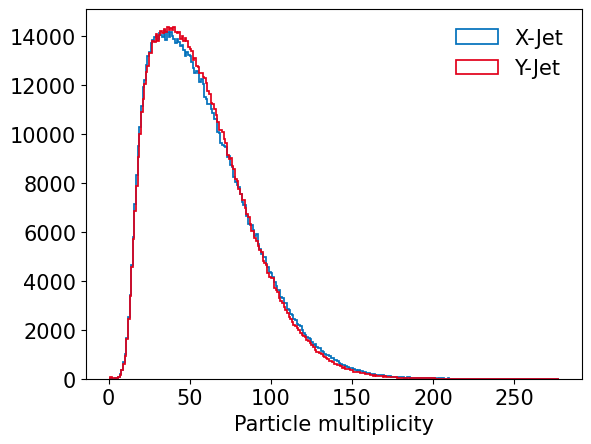

In [32]:
fig, ax = plt.subplots()
# skip colours in the cycle
next(ax._get_lines.prop_cycler)
next(ax._get_lines.prop_cycler)
hist = ax.hist(np.sum(mask_background[:,0],axis=1).flatten(), bins=range(0,max_consts,1), label="X-Jet", histtype='step')
ax.hist(np.sum(mask_background[:,1],axis=1).flatten(), bins=hist[1], label="Y-Jet", histtype='step')
ax.set_xlabel('Particle multiplicity')
plt.legend(frameon=False)
plt.show()

### Signal

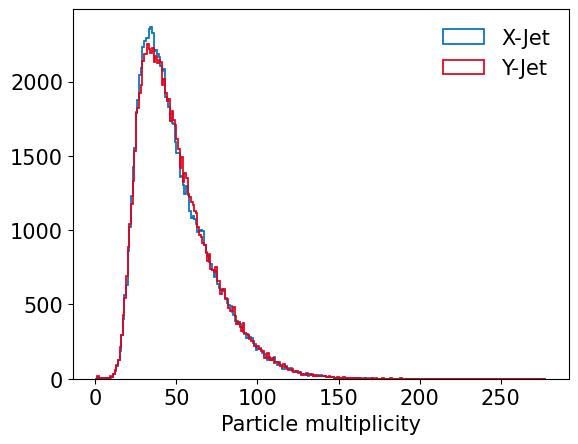

In [33]:
fig, ax = plt.subplots()
# skip colours in the cycle
next(ax._get_lines.prop_cycler)
next(ax._get_lines.prop_cycler)
hist = ax.hist(np.sum(mask_signal[:,0],axis=1).flatten(), bins=range(0,max_consts,1), label="X-Jet", histtype='step')
ax.hist(np.sum(mask_signal[:,1],axis=1).flatten(), bins=hist[1], label="Y-Jet", histtype='step')
ax.set_xlabel('Particle multiplicity')
plt.legend(frameon=False)
plt.show()

## Constituent Features

In [34]:
x_background = consts_background[:,0]
y_background = consts_background[:,1]
x_signal = consts_signal[:,0]
y_signal = consts_signal[:,1]
print(x_background.shape)

(1000000, 279, 3)


### Background

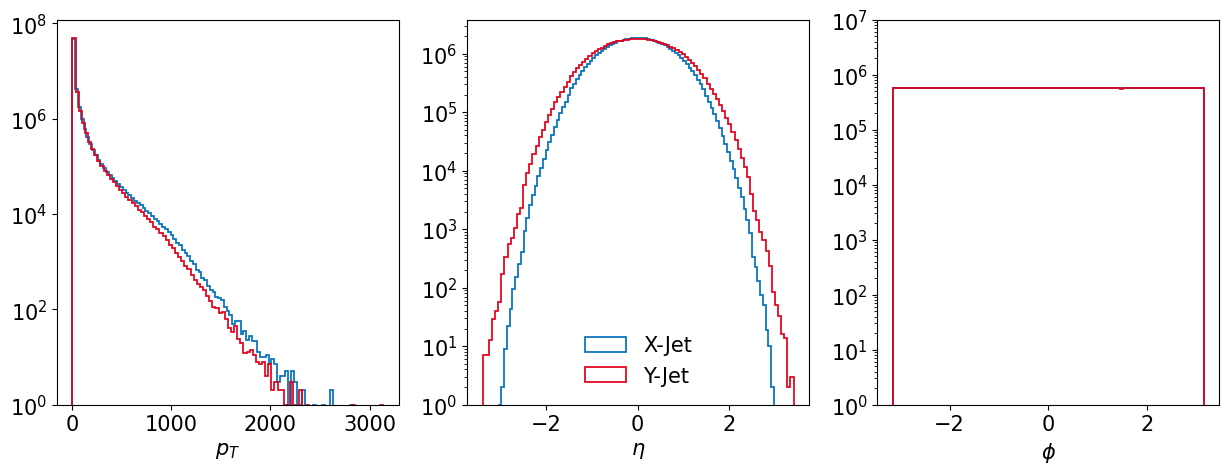

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # skip colours in the cycle
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        x_background[:, :, index].flatten()[x_background[:, :, index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        y_background[:, :, index].flatten()[y_background[:, :, index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

### Signal

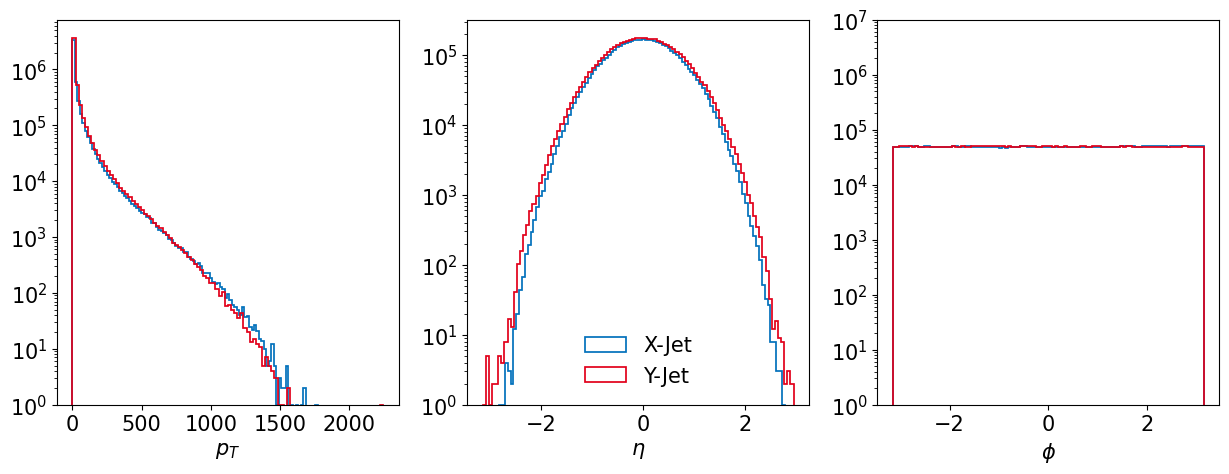

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # skip colours in the cycle
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        x_signal[:, :, index].flatten()[x_signal[:, :, index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        y_signal[:, :, index].flatten()[y_signal[:, :, index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

## Jet Features

### Load and prepare provided features

In [37]:
path_features = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.features.h5"

In [38]:
df = pd.read_hdf(path_features)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))


(1100000, 15)
Memory in GB: 0.13113021850585938


In [39]:
feats = np.array(df)
background_feats = feats[feats[...,-1]==0][:,:-1]
signal_feats = feats[feats[...,-1]==1][:,:-1]
print(background_feats.shape)
print(signal_feats.shape)

(1000000, 14)
(100000, 14)


In [40]:
def to_ptyphim(feats):
    """  px, py, pz, mj --> pt, eta, phi, mj"""
    p3 = feats[:, :3]
    e = np.sqrt(feats[:, 0]**2 + feats[:, 1]**2 + feats[:, 2]**2 + feats[:, 3]**2)
    p4 = np.concatenate((e[:, None],p3), axis=1)
    ptyphim = ef.ptyphims_from_p4s(p4, phi_ref=0)
    return ptyphim

In [41]:
feats_x_background = to_ptyphim(background_feats[:,:4])
feats_y_background = to_ptyphim(background_feats[:,7:11])
feats_x_signal = to_ptyphim(signal_feats[:,:4]) 
feats_y_signal = to_ptyphim(signal_feats[:,7:11])

### Prepare fastjet data

In [42]:
jets_x_background = jets_background[:,0]
jets_y_background = jets_background[:,1]
jets_x_signal = jets_signal[:,0]
jets_y_signal = jets_signal[:,1]

alternatively, we can calculate the jet features from the jet constituents directly

In [43]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    return jet_data

In [44]:
jets_x_background_calc = get_jet_data(x_background)
jets_y_background_calc = get_jet_data(y_background)
jets_x_signal_calc = get_jet_data(x_signal)
jets_y_signal_calc = get_jet_data(y_signal)

### Background

#### X-Jet

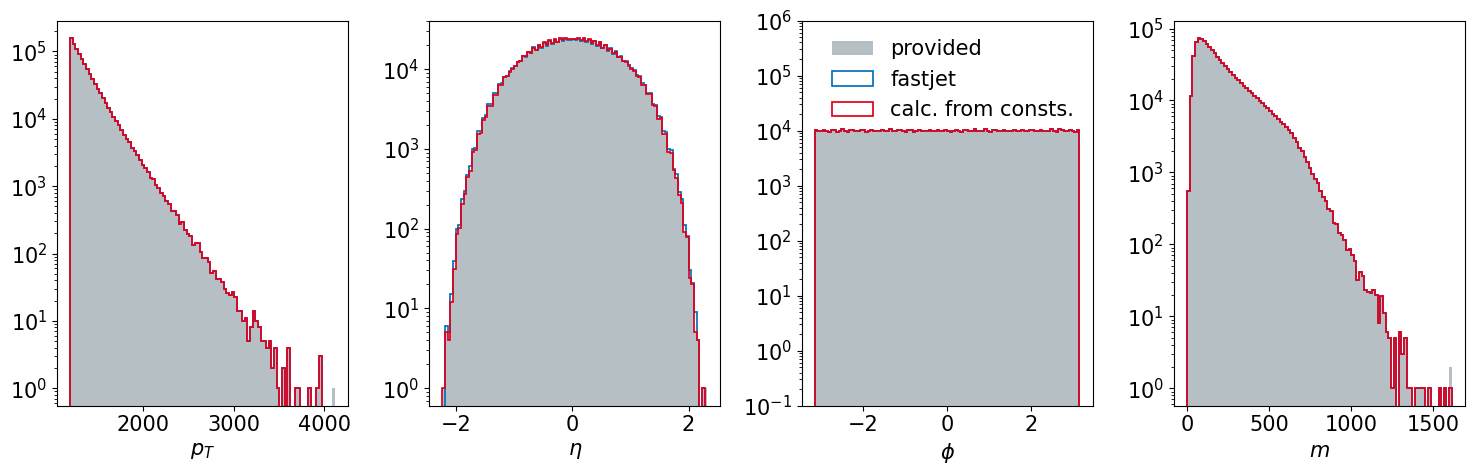

In [45]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_x_background[:, index], bins=100, label="provided"
    )
    next(ax._get_lines.prop_cycler)
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_x_background[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.hist(jets_x_background_calc[:,index],bins=hist1[1], histtype='step', label="calc. from consts.")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

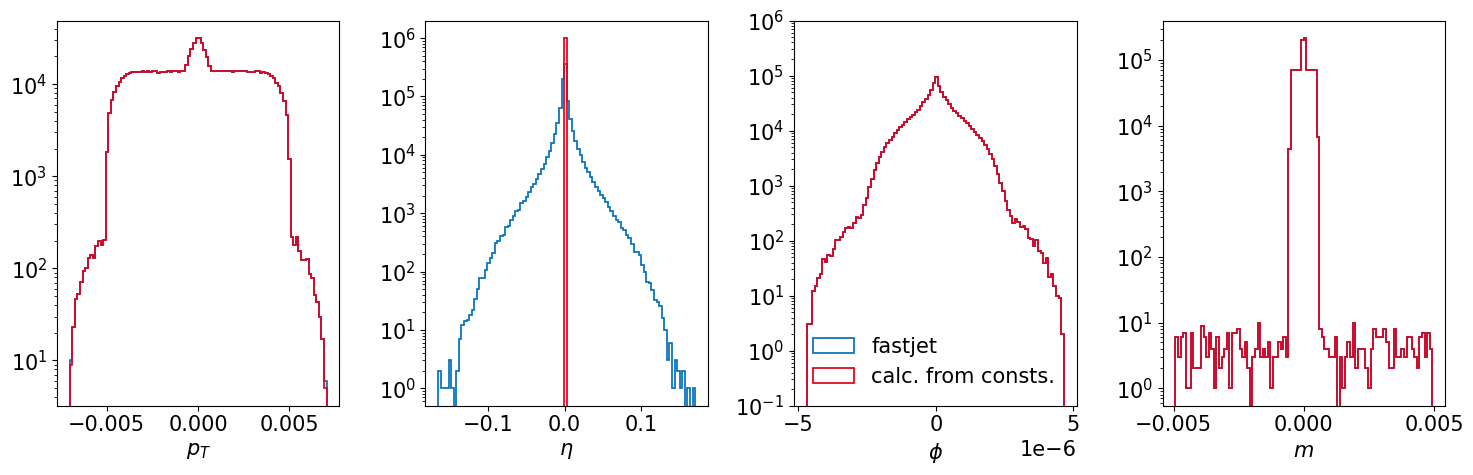

In [46]:
diff_background_x = feats_x_background - jets_x_background
diff_background_x_calc = feats_x_background - jets_x_background_calc
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    hist1 = ax.hist(
        diff_background_x[:, index], bins=100, label="fastjet", histtype="step"
    )
    ax.hist(
        diff_background_x_calc[:, index], bins=hist1[1], label="calc. from consts.", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

#### Y-Jet

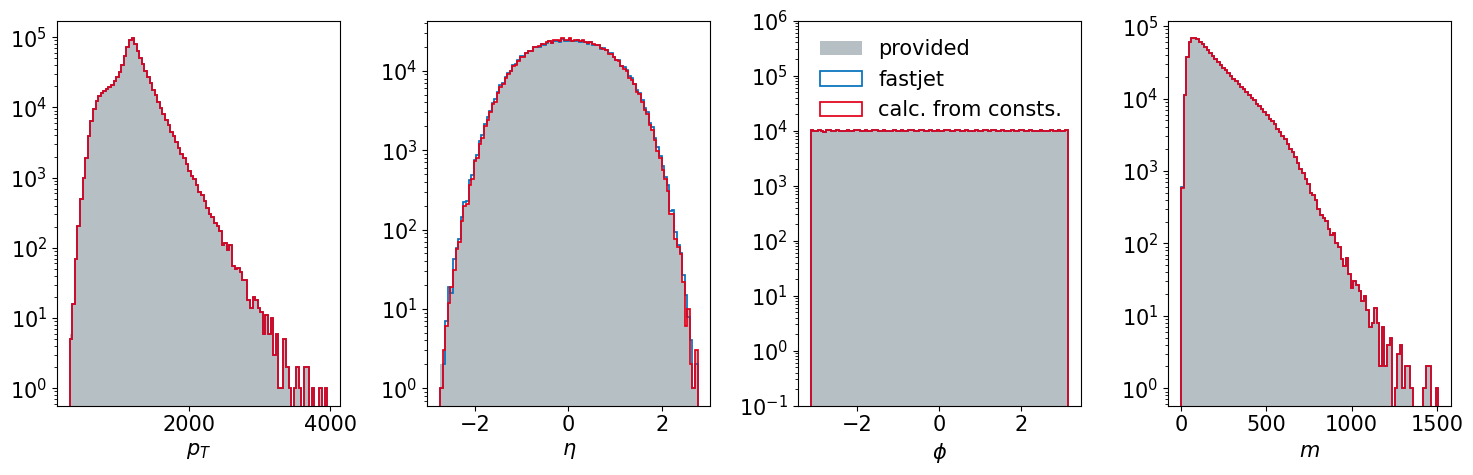

In [47]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_y_background[:, index], bins=100, label="provided"
    )
    next(ax._get_lines.prop_cycler)
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_y_background[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.hist(jets_y_background_calc[:,index],bins=hist1[1], histtype='step', label="calc. from consts.")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1,1e6)
plt.tight_layout()
plt.show()

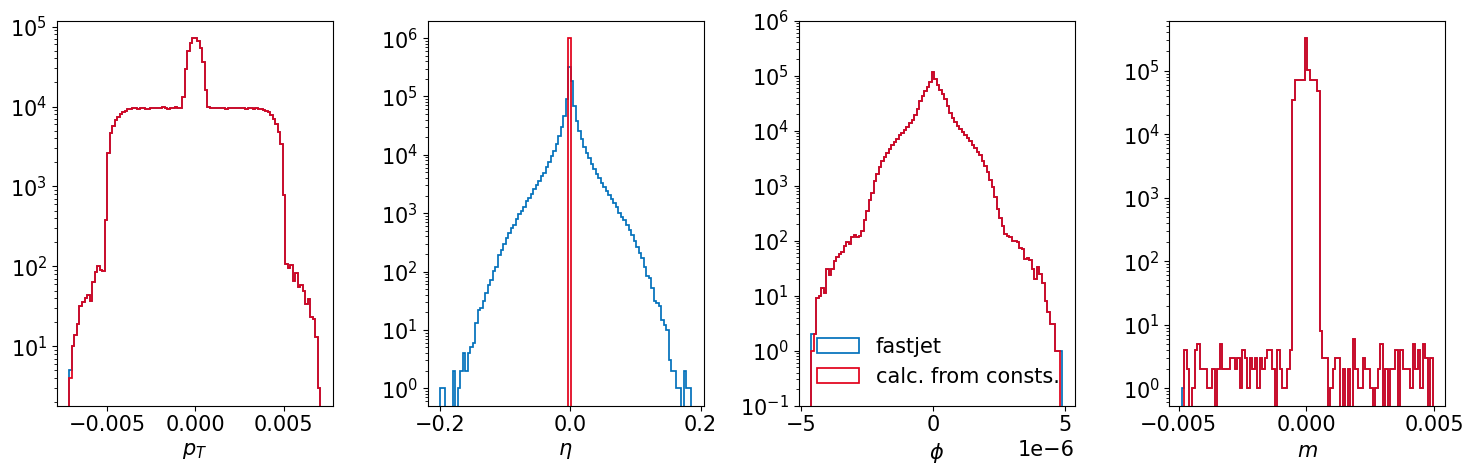

In [48]:
diff_background_y = feats_y_background - jets_y_background
diff_background_y_calc = feats_y_background - jets_y_background_calc
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    hist1 = ax.hist(
        diff_background_y[:, index], bins=100, label="fastjet", histtype="step"
    )
    ax.hist(
        diff_background_y_calc[:, index], bins=hist1[1], label="calc. from consts.", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

### Signal

#### X-Jet

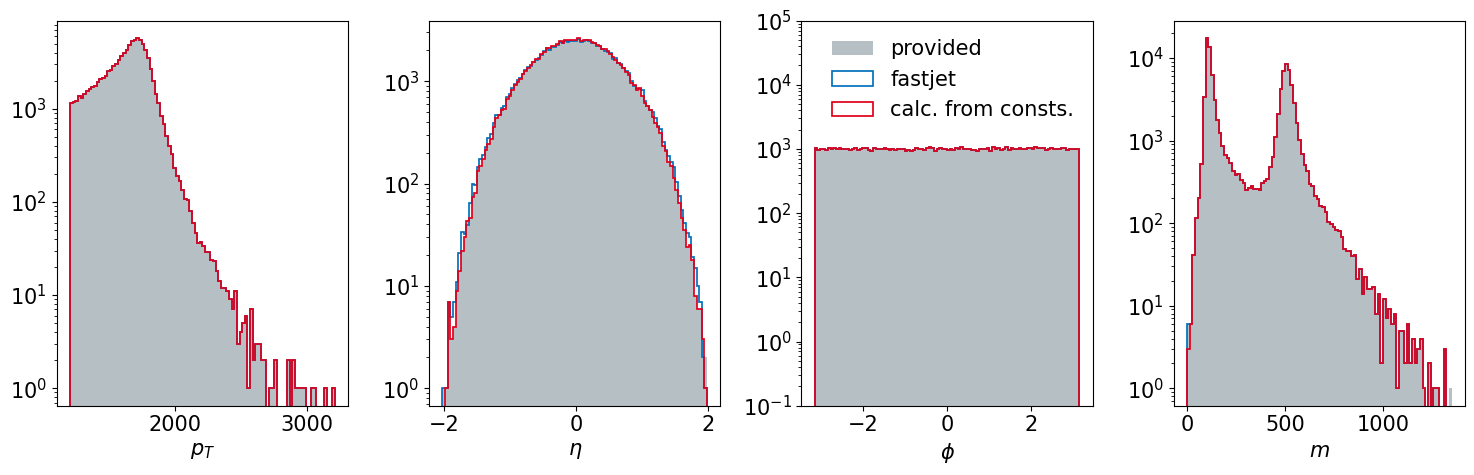

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_x_signal[:, index], bins=100, label="provided"
    )
    next(ax._get_lines.prop_cycler)
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_x_signal[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.hist(jets_x_signal_calc[:,index],bins=hist1[1], histtype='step', label="calc. from consts.")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)
plt.tight_layout()
plt.show()

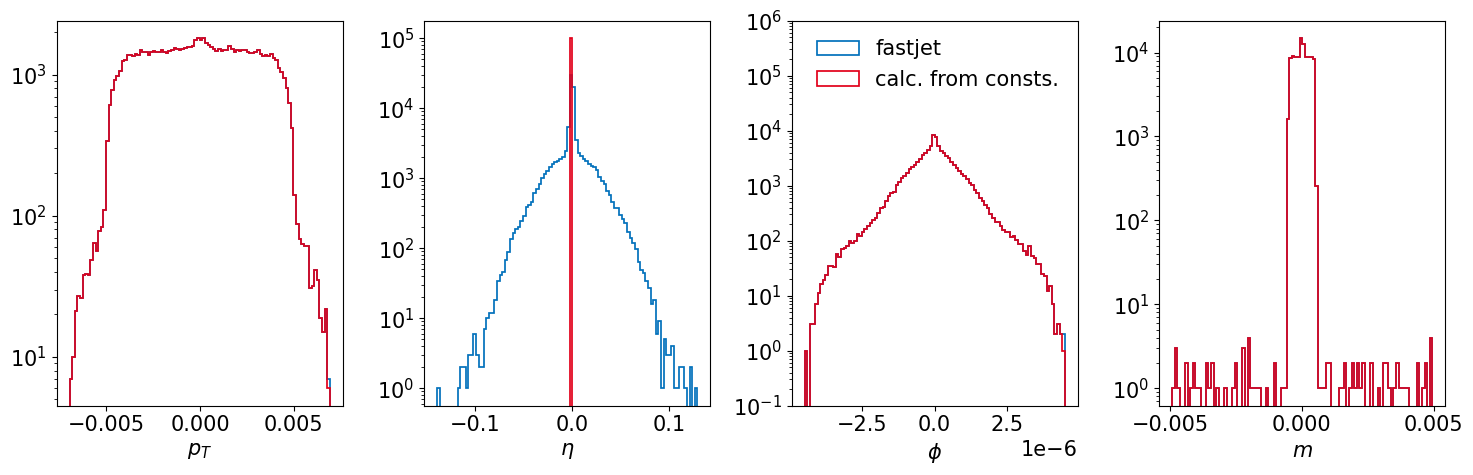

In [50]:
diff_signal_x = feats_x_signal - jets_x_signal
diff_signal_x_calc = feats_x_signal - jets_x_signal_calc
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    hist1 = ax.hist(
        diff_signal_x[:, index], bins=100, label="fastjet", histtype="step"
    )
    ax.hist(
        diff_signal_x_calc[:, index], bins=hist1[1], label="calc. from consts.", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

#### Y-Jets

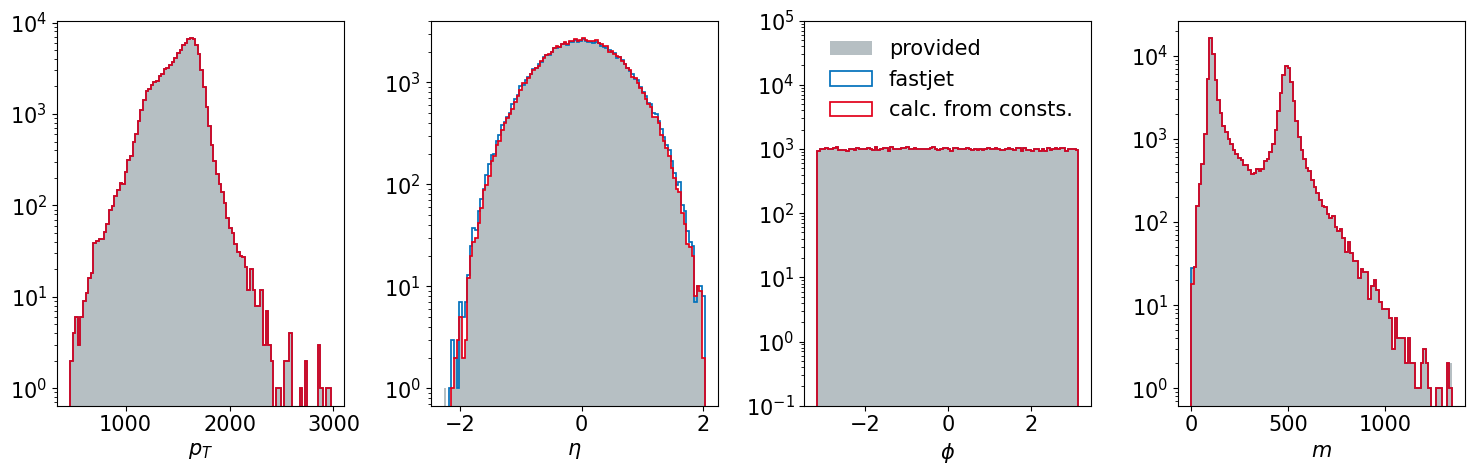

In [51]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_y_signal[:, index], bins=100, label="provided"
    )
    next(ax._get_lines.prop_cycler)
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_y_signal[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.hist(jets_y_signal_calc[:,index],bins=hist1[1], histtype='step', label="calc. from consts.")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)
plt.tight_layout()
plt.show()

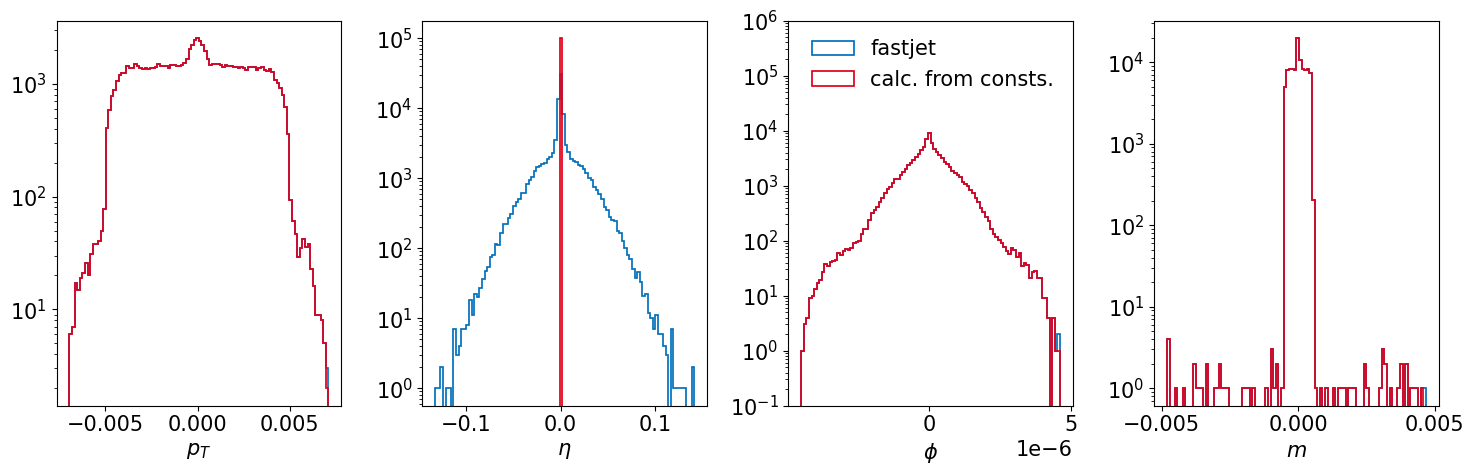

In [52]:
diff_signal_y = feats_y_signal - jets_y_signal
diff_signal_y_calc = feats_y_signal - jets_y_signal_calc
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    hist1 = ax.hist(
        diff_signal_y[:, index], bins=100, label="fastjet", histtype="step"
    )
    ax.hist(
        diff_signal_y_calc[:, index], bins=hist1[1], label="calc. from consts.", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

# Calculate Relative Coordinates
In the following, the coordinates for the constituents will be calculated relative to the jet axis. The relative coordinates are useful because they result in distributions that are easier to model with a neural network. The relative coordinates are defined as follows:
\begin{equation}
    \phi_{rel} = \phi / \phi_{jet}
\end{equation}

\begin{equation}
    \eta_{rel} = \eta - \eta_{jet}
\end{equation}

\begin{equation}
    p_{T,rel} = p_T - p_{T,jet}
\end{equation} 

In [53]:
# calculate jet features
jet_data_calc = get_jet_data(consts)

In [54]:
# calculate relative pt, eta, phi
rel_pt = consts[..., 0] / np.expand_dims(jet_data_calc[..., 0], axis=-1)
rel_eta = consts[..., 1] - np.expand_dims(jet_data_calc[..., 1], axis=-1)
rel_phi = consts[..., 2] - np.expand_dims(jet_data_calc[..., 2], axis=-1)
rel_pt = np.expand_dims(rel_pt, axis=-1)
rel_eta = np.expand_dims(rel_eta, axis=-1)
rel_phi = np.expand_dims(rel_phi, axis=-1)

In [55]:
# wrap phi between -pi and pi
rel_phi = np.where(
    rel_phi > np.pi,
    rel_phi - 2 * np.pi,
    rel_phi,
)
rel_phi = np.where(
    rel_phi < -np.pi,
    rel_phi + 2 * np.pi,
    rel_phi,
)

In [56]:
# fix the masking
rel_phi = rel_phi * mask
rel_eta = rel_eta * mask

In [57]:
consts_rel = np.concatenate((rel_pt, rel_eta, rel_phi), axis=-1)
print(consts_rel.shape)

(1100000, 2, 279, 3)


## Save Data

In [58]:
consts_rel_background = consts_rel[:len_bckg]
consts_rel_signal = consts_rel[len_bckg:]
jets_calc_background = jet_data_calc[:len_bckg]
jets_calc_signal = jet_data_calc[len_bckg:]

In [59]:
final_path_rel = "/beegfs/desy/user/ewencedr/data/lhco/final_data/"

In [60]:
background_path_rel = final_path + "processed_data_background_rel.h5"
signal_path_rel = final_path + "processed_data_signal_rel.h5"
with h5py.File(background_path_rel, "w") as f:
    f.create_dataset("jet_data", data=jets_calc_background)
    f.create_dataset("constituents", data=consts_rel_background)  
    f.create_dataset("mask", data=mask_background)  
with h5py.File(signal_path_rel, "w") as f:
    f.create_dataset("jet_data", data=jets_calc_signal)
    f.create_dataset("constituents", data=consts_rel_signal)  
    f.create_dataset("mask", data=mask_signal)  

## Plots Constituents

In [61]:
# these will be the x-axis labels for the histograms
label_map_rel = {"0": "$p_\mathrm{T}^\mathrm{rel}$", "1": "$\eta^\mathrm{rel}$", "2": "$\phi^\mathrm{rel}$", "3": "$m$"}

In [62]:
consts_rel_background_x = consts_rel_background[:, 0]
consts_rel_background_y = consts_rel_background[:, 1]
consts_rel_signal_x = consts_rel_signal[:, 0]
consts_rel_signal_y = consts_rel_signal[:, 1]

### Background

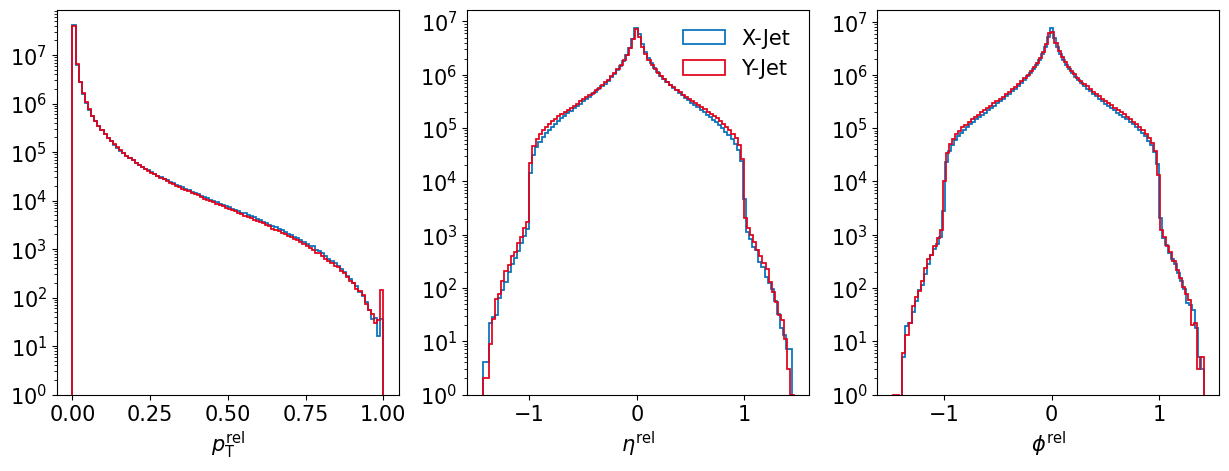

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # skip colours in the cycle
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        consts_rel_background_x[..., index].flatten()[consts_rel_background_x[..., index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        consts_rel_background_y[..., index].flatten()[consts_rel_background_y[..., index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )

    ax.set_xlabel(f"{label_map_rel[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

### Signal

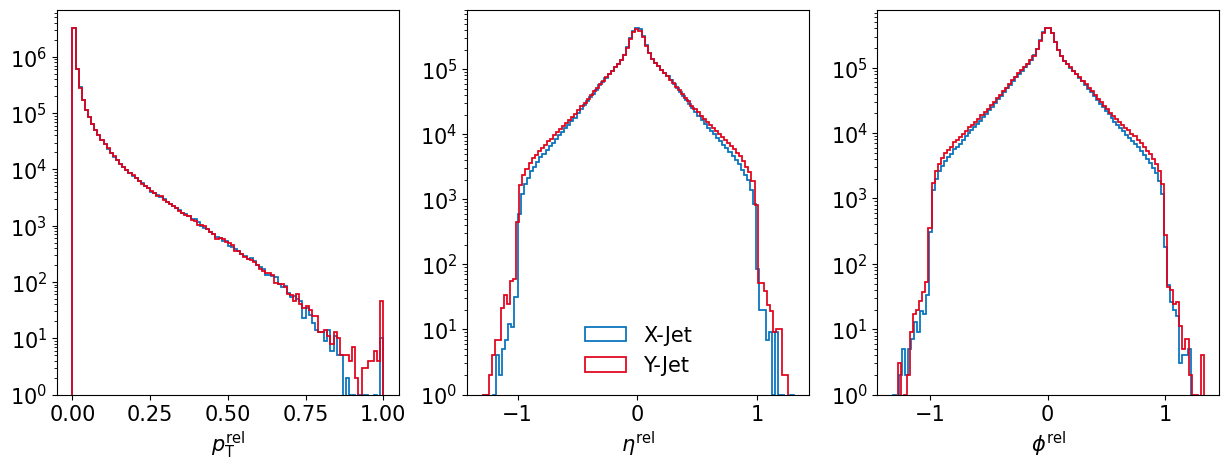

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # skip colours in the cycle
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        consts_rel_signal_x[..., index].flatten()[consts_rel_signal_x[..., index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        consts_rel_signal_y[..., index].flatten()[consts_rel_signal_y[..., index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )

    ax.set_xlabel(f"{label_map_rel[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

## Plots Jet
One can also calculate the jet features based on the relative constituents.

In [65]:
jet_data_rel = get_jet_data(consts_rel)
print(jet_data_rel.shape)

(1100000, 2, 4)


In [66]:
jets_rel_background_x = jet_data_rel[:len_bckg, 0]
jets_rel_background_y = jet_data_rel[:len_bckg, 1]
jets_rel_signal_x = jet_data_rel[:len_bckg, 0]
jets_rel_signal_y = jet_data_rel[:len_bckg, 1]

### Background

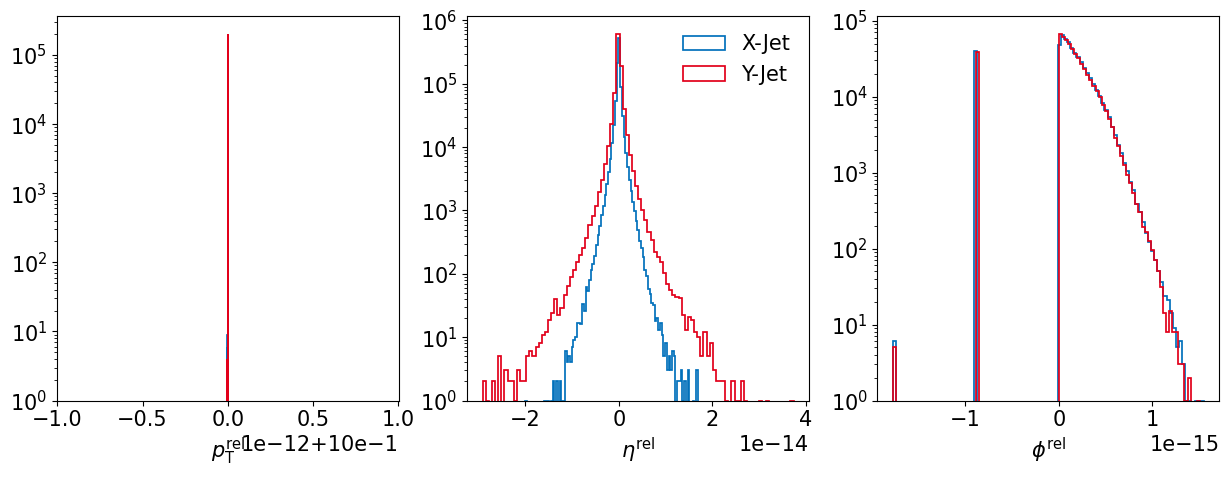

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # skip colours in the cycle
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        jets_rel_background_x[..., index].flatten()[jets_rel_background_x[..., index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        jets_rel_background_y[..., index].flatten()[jets_rel_background_y[..., index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )

    ax.set_xlabel(f"{label_map_rel[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

### Signal

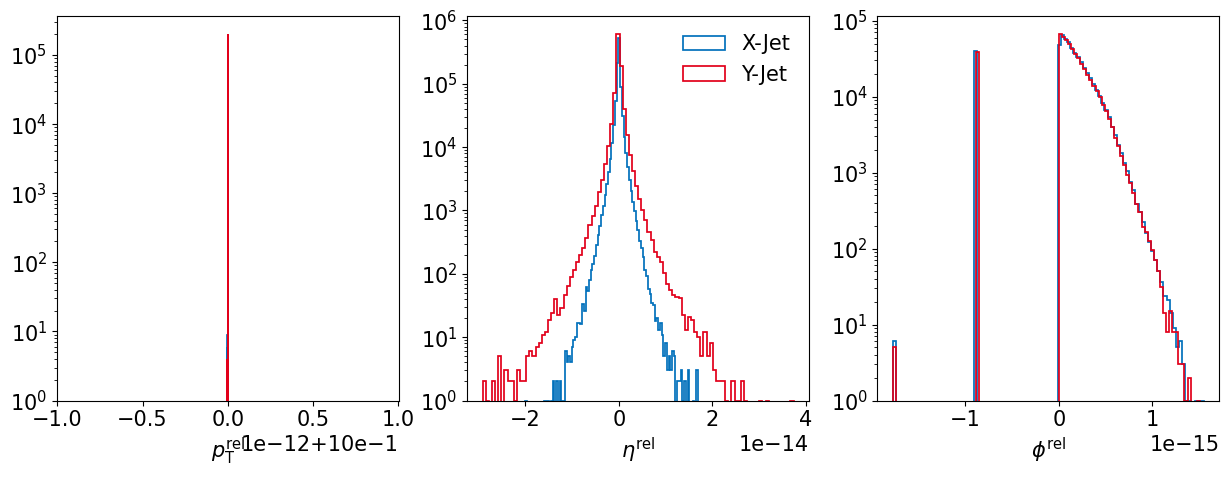

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # skip colours in the cycle
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        jets_rel_signal_x[..., index].flatten()[jets_rel_signal_x[..., index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        jets_rel_signal_y[..., index].flatten()[jets_rel_signal_y[..., index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )

    ax.set_xlabel(f"{label_map_rel[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index == 1:
        ax.legend(frameon=False)
plt.show()